In [21]:
import os
import zipfile
import random
import shutil
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from shutil import copyfile
import matplotlib.pyplot as plt

In [22]:
local_zip = 'DatasetTomato.zip'
zip_ref   = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('Tomat')
zip_ref.close()

In [23]:
import os

image_dir = 'Tomat'

items = os.listdir(image_dir)
print(items)

['Mosaic virus', 'Yellow Leaf Curl Virus', 'Early blight', 'Late blight', 'healthy', 'Target Spot', 'Bacterial spot', 'Spider mites Two spotted spider mite', 'Leaf Mold', 'Septoria leaf spot']


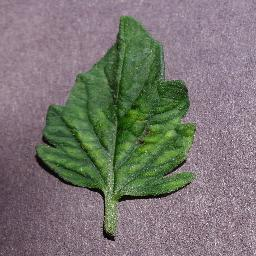

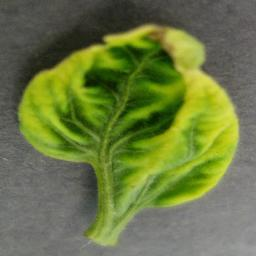

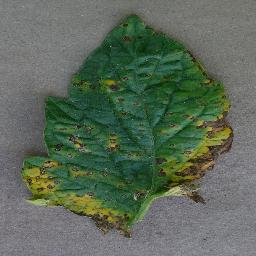

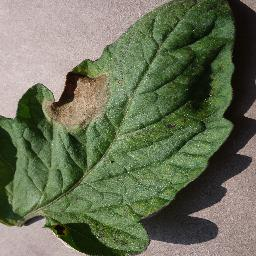

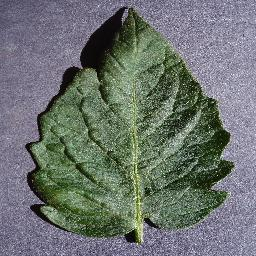

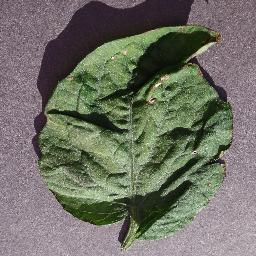

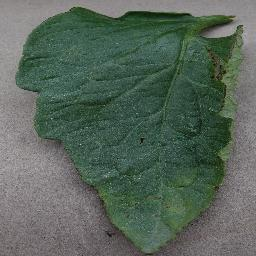

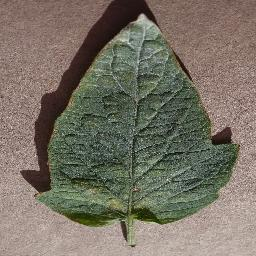

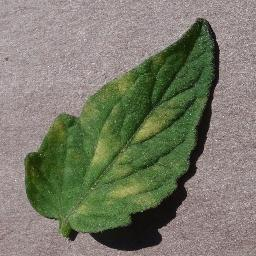

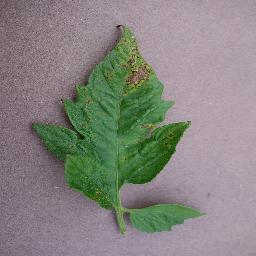

In [55]:
from IPython.display import display, Image, HTML

image_dir = 'Tomat'

# melist semua image direktori
folders = [f for f in os.listdir(image_dir) if os.path.isdir(os.path.join(image_dir, f))]

# Menampilkan 1 sampel dari setiap folder disease mangga
for folder in folders:
    folder_path = os.path.join(image_dir, folder)
    images = [f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]
    if images:
        sample_image = images[0]
        image_path = os.path.join(folder_path, sample_image)
        display(HTML(f'<h3>{folder}</h3>'))
        display(Image(filename=image_path, width=200))

In [26]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    'Tomat',
    shuffle=True,
    image_size = (256, 256),
    batch_size = 32)

Found 4208 files belonging to 10 classes.


In [56]:
class_names = dataset.class_names
class_names

['Bacterial spot',
 'Early blight',
 'Late blight',
 'Leaf Mold',
 'Mosaic virus',
 'Septoria leaf spot',
 'Spider mites Two spotted spider mite',
 'Target Spot',
 'Yellow Leaf Curl Virus',
 'healthy']

In [28]:
dataset_size = len(dataset)
print(dataset_size)

132


In [29]:
def split_dataset(ds, train_ratio=0.8, val_ratio=0.1, test_ratio=0.1, shuffle=True):
    # menegatur
    dataset_size = len(ds)

    # Calculate split sizes
    train_size = int(train_ratio * dataset_size)
    val_size = int(val_ratio * dataset_size)
    test_size = dataset_size - train_size - val_size

    # Shuffle dataset if required
    if shuffle:
        ds = ds.shuffle(dataset_size)

    # Split dataset
    train_dataset = ds.take(train_size)
    val_dataset = ds.skip(train_size).take(val_size)
    test_dataset = ds.skip(train_size + val_size).take(test_size)

    return train_dataset, val_dataset, test_dataset

In [30]:
# Example usage:
train_ds, val_ds, test_ds = split_dataset(dataset)

In [31]:
for i in [train_ds, val_ds, test_ds]:
    print(len(i))

105
13
14


In [32]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

In [33]:
resize_and_rescale = tf.keras.Sequential([
    tf.keras.layers.Resizing(256,256),     # Though already resized, this works for other test data
    tf.keras.layers.Rescaling(1.0/255)     # Normalizing the pixels
])

In [34]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip(mode="horizontal_and_vertical"),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(height_factor=(-0.2, 0.2), width_factor=(-0.2, 0.2)),
    tf.keras.layers.RandomBrightness(0.1),
    tf.keras.layers.RandomContrast(0.1),
])

In [35]:
from tensorflow.keras.regularizers import l2
from tensorflow.keras.regularizers import l1

In [36]:
from tensorflow.keras.optimizers import Adam
resize_and_rescale,
data_augmentation,

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu', input_shape=(256, 256, 3)),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
  tf.keras.layers.Conv2D(128, kernel_size=(3, 3), padding='same', activation='relu'),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),

  tf.keras.layers.Conv2D(256, kernel_size=(3, 3), padding='same', activation='relu'),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),

  # Flatten layer
  tf.keras.layers.Flatten(),

  # Add fully connected layers with dropout and regularization
  tf.keras.layers.Dense(256, activation='relu', kernel_regularizer=l2(0.001)),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=l2(0.001)),
  tf.keras.layers.Dropout(0.1),
  tf.keras.layers.Dense(10, activation='softmax')
])

In [37]:
optimizer = Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [38]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 64)      1792      
                                                                 
 batch_normalization (Batch  (None, 256, 256, 64)      256       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 128, 128, 64)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 128)     73856     
                                                                 
 batch_normalization_1 (Bat  (None, 128, 128, 128)     512       
 chNormalization)                                                
                                                      

In [40]:
history = model.fit(train_ds, epochs = 20, batch_size = 32, verbose = 1, validation_data = val_ds)

Epoch 1/20
105/105 [==============================] - 41s 255ms/step - loss: 3.6538 - accuracy: 0.4764 - val_loss: 2.2284 - val_accuracy: 0.4688
Epoch 2/20
105/105 [==============================] - 20s 186ms/step - loss: 1.6852 - accuracy: 0.6860 - val_loss: 1.2855 - val_accuracy: 0.8221
Epoch 3/20
105/105 [==============================] - 19s 183ms/step - loss: 1.4257 - accuracy: 0.7742 - val_loss: 1.1545 - val_accuracy: 0.8462
Epoch 4/20
105/105 [==============================] - 19s 183ms/step - loss: 1.2485 - accuracy: 0.8307 - val_loss: 0.9793 - val_accuracy: 0.8942
Epoch 5/20
105/105 [==============================] - 19s 183ms/step - loss: 1.0969 - accuracy: 0.8618 - val_loss: 0.8393 - val_accuracy: 0.9351
Epoch 6/20
105/105 [==============================] - 19s 182ms/step - loss: 0.9661 - accuracy: 0.8995 - val_loss: 0.8117 - val_accuracy: 0.9471
Epoch 7/20
105/105 [==============================] - 19s 183ms/step - loss: 0.9212 - accuracy: 0.9040 - val_loss: 0.8284 - val_ac

In [41]:
scores = model.evaluate(test_ds)

14/14 [==============================] - 5s 52ms/step - loss: 0.6450 - accuracy: 0.9598


In [42]:
scores

[0.64497309923172, 0.9598214030265808]

In [43]:
history

In [44]:
history.params

{'verbose': 1, 'epochs': 20, 'steps': 105}

In [45]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [46]:
type(history.history['loss'])

list

In [47]:
len(history.history['loss'])

20

In [48]:
history.history['loss'][:5] # show loss for first 5 epochs

[3.6537954807281494,
 1.6852002143859863,
 1.425656795501709,
 1.2484514713287354,
 1.0969465970993042]

In [49]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

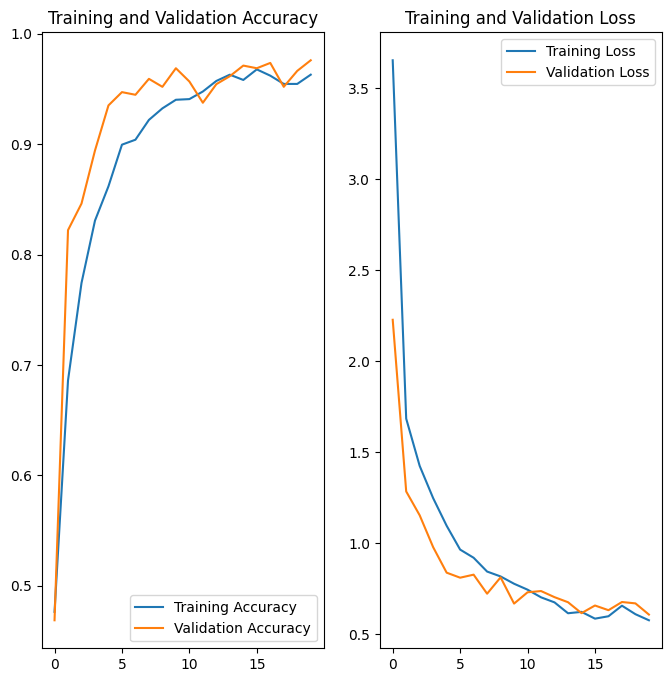

In [51]:
EPOCHS = 20
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Predict On Sample Image

first image to predict
actual label: Target Spot
1/1 [==============================] - 0s 203ms/step
predicted label: Target Spot


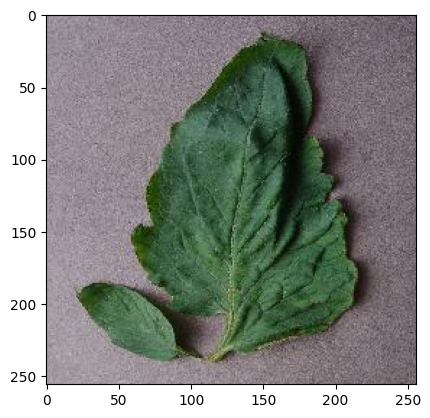

In [57]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):

    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()

    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])

    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [58]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 19ms/step


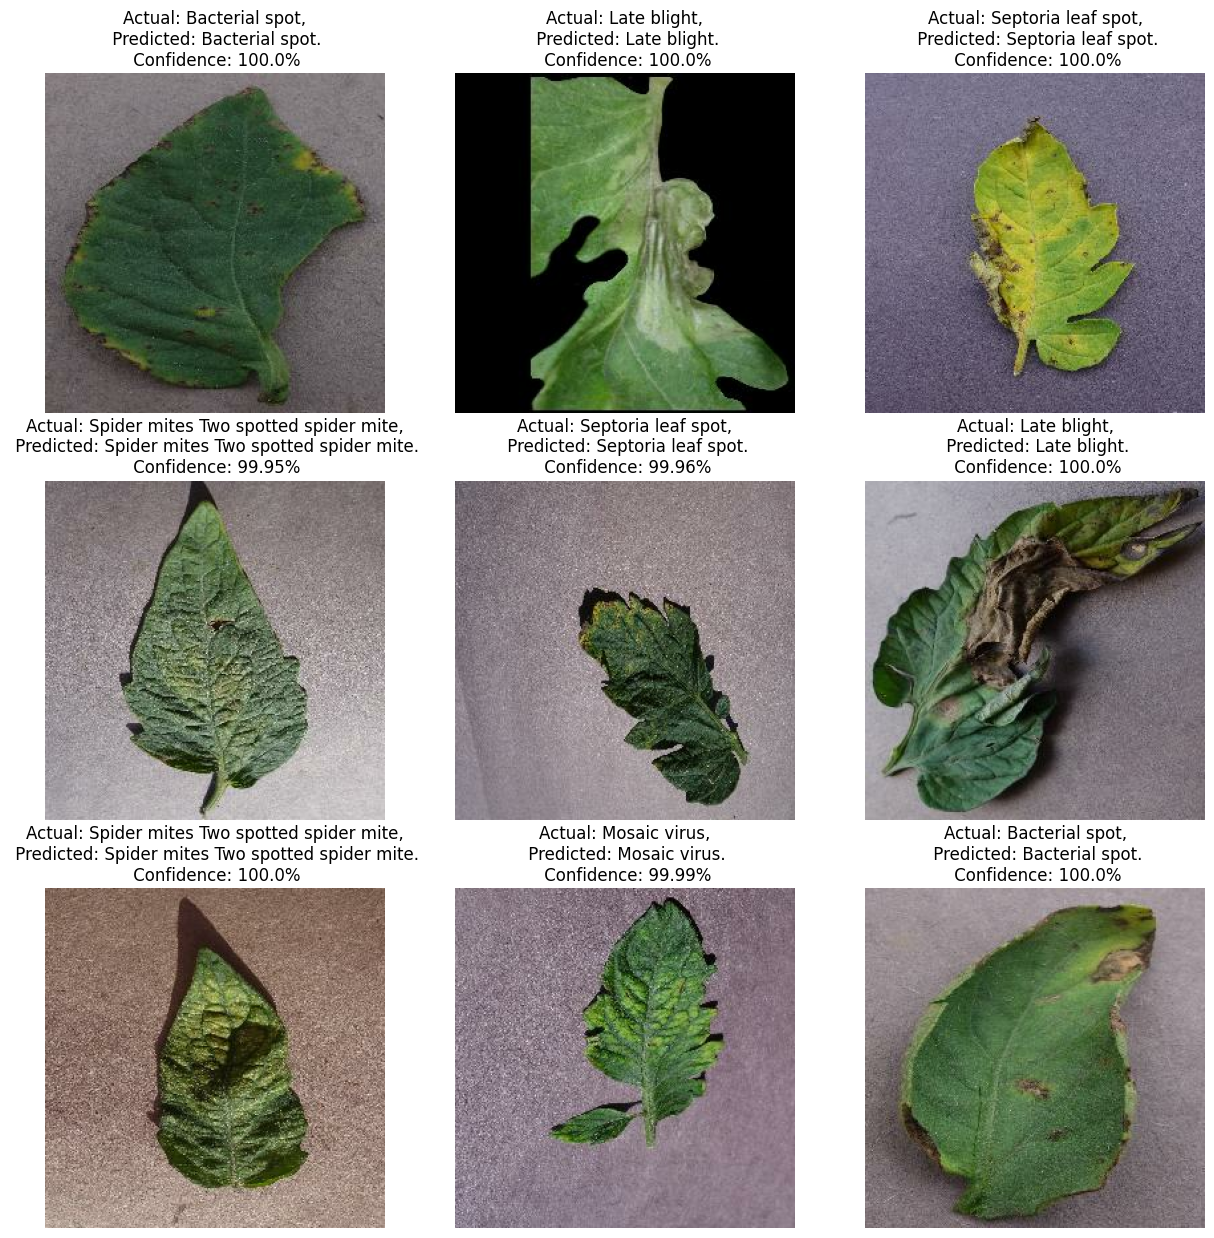

In [59]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))

        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]

        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")

        plt.axis("off")

In [ ]:
model.save("../tomato.h5")